<a href="https://colab.research.google.com/github/ledwabarefentse/cnn/blob/main/Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
import xml.etree.ElementTree as ET
import pandas as pd
import tensorflow as tf

In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/Mydrive')


Drive already mounted at /content/Mydrive; to attempt to forcibly remount, call drive.mount("/content/Mydrive", force_remount=True).


In [ ]:
!git clone --q https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [ ]:
!cp models/research/object_detection/packages/tf2/setup.py .

In [ ]:
!pip install protobuf==3.19.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!python setup.py build
!python setup.py install

running build
running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other sta

In [ ]:
%cd models/research
!protoc object_detection/protos/*.proto --python_out=.

/content/models/research


In [ ]:
%set_env PYTHONPATH=$PYTHONPATH:/content/models/research:/content/models/research/slim:/content/models

env: PYTHONPATH=$PYTHONPATH:/content/models/research:/content/models/research/slim:/content/models


In [ ]:
!python object_detection/builders/model_builder_tf2_test.py

Traceback (most recent call last):
  File "/content/models/research/object_detection/builders/model_builder_tf2_test.py", line 21, in <module>
    import tensorflow.compat.v1 as tf
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/__init__.py", line 37, in <module>
    from tensorflow.python.tools import module_util as _module_util
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/__init__.py", line 37, in <module>
    from tensorflow.python.eager import context
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 28, in <module>
    from tensorflow.core.framework import function_pb2
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/core/framework/function_pb2.py", line 5, in <module>
    from google.protobuf.internal import builder as _builder
ImportError: cannot import name 'builder' from 'google.protobuf.internal' (/usr/local/lib/python3.10/dist-packages/google/protobuf/internal/__init__.py)


In [ ]:
%cd /content/Mydrive/MyDrive/archive/Data

/content/Mydrive/MyDrive/archive/Data


In [ ]:
def xml_to_csv(path):
  classes_names = []
  xml_list = []

  for xml_file in glob.glob(path + '/*.xml'):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for member in root.findall('object'):
      indexer=1
      if len(member)>2:
        indexer = 4
      classes_names.append(member[0].text)
      value = (root.find('filename').text.replace("xml","jpg")  ,
               int(root.find('size')[0].text),
               int(root.find('size')[1].text),
               member[0].text,
               int(member[indexer][0].text),
               int(member[indexer][1].text),
               int(member[indexer][2].text),
               int(member[indexer][3].text))
      xml_list.append(value)
  column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
  xml_df = pd.DataFrame(xml_list, columns=column_name)
  classes_names = list(set(classes_names))
  classes_names.sort()
  return xml_df, classes_names

for label_path in ['train_labels', 'test_labels']:
  image_path = os.path.join(os.getcwd(), label_path)
  xml_df, classes = xml_to_csv(label_path)
  xml_df.to_csv(f'{label_path}.csv', index=None)
  print(f'Successfully converted {label_path} xml to csv.')

label_map_path = os.path.join("label_map.pbtxt")
pbtxt_content = ""

for i, class_name in enumerate(classes):
    pbtxt_content = (
        pbtxt_content
        + "item {{\n    id: {0}\n    name: '{1}'\n}}\n\n".format(i + 1, class_name)
    )
pbtxt_content = pbtxt_content.strip()
with open(label_map_path, "w") as f:
    f.write(pbtxt_content)
    print('Successfully created label_map.pbtxt ')

Successfully converted train_labels xml to csv.
Successfully converted test_labels xml to csv.
Successfully created label_map.pbtxt 


In [ ]:
!cp /content/models/research/object_detection/configs/tf2/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config /content/Mydrive/MyDrive/archive/Data

In [ ]:
!python /content/generate_tfrecord.py train_labels.csv  label_map.pbtxt /content/Mydrive/MyDrive/archive/JPEGImages train.record

python3: can't open file '/content/generate_tfrecord.py': [Errno 2] No such file or directory


In [ ]:
%cd /content/models/research

/content/models/research


In [ ]:
#Loading the saved_model
import tensorflow as tf
import time
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
from google.colab.patches import cv2_imshow
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

IMAGE_SIZE = (12, 8) # Output display size as you want
import matplotlib.pyplot as plt
PATH_TO_SAVED_MODEL="/content/Mydrive/MyDrive/archive 2/Data/inference_graph/saved_model"
print('Loading model...', end='')

# Load saved model and build the detection function
detect_fn=tf.saved_model.load(PATH_TO_SAVED_MODEL)
print('Done!')

#Loading the label_map
category_index=label_map_util.create_category_index_from_labelmap("/content/Mydrive/MyDrive/archive 2/Data/label_map.pbtxt",use_display_name=True)
#category_index=label_map_util.create_category_index_from_labelmap([path_to_label_map],use_display_name=True)

def load_image_into_numpy_array(path):

    return np.array(Image.open(path))


Loading model...Done!


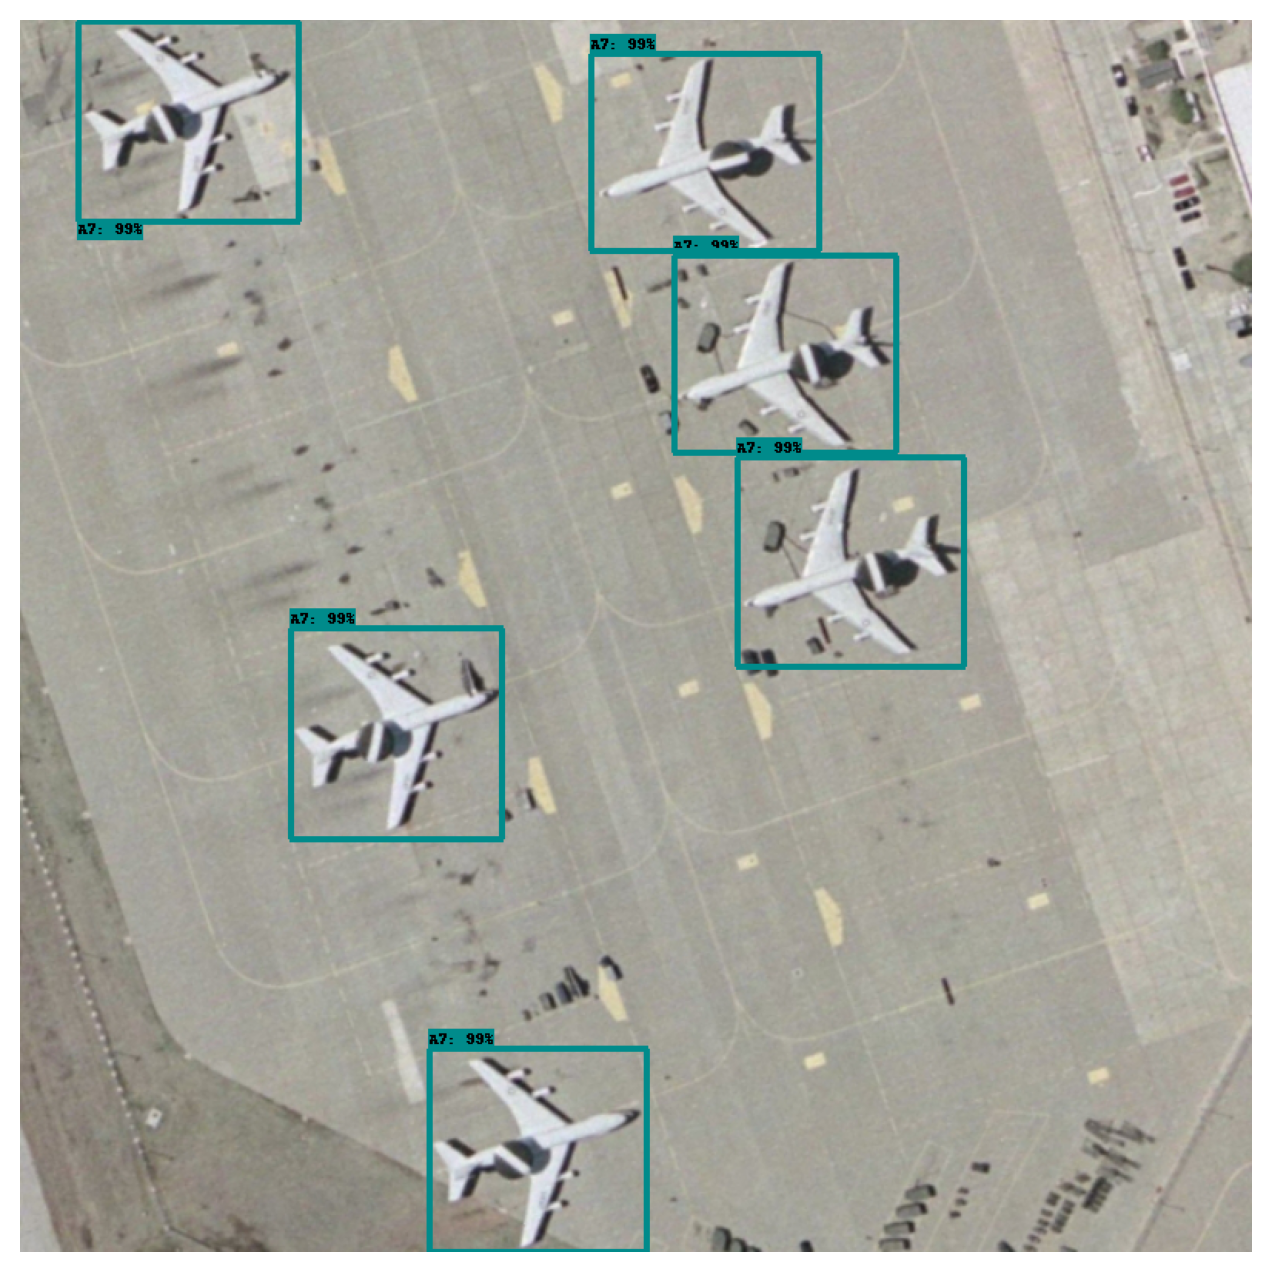

In [ ]:
image_path = "/content/Mydrive/MyDrive/archive 2/JPEGImages/2641.jpg"
#print('Running inference for {}... '.format(image_path), end='')

image_np = load_image_into_numpy_array(image_path)

# The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
input_tensor = tf.convert_to_tensor(image_np)
# The model expects a batch of images, so add an axis with `tf.newaxis`.
input_tensor = input_tensor[tf.newaxis, ...]

detections = detect_fn(input_tensor)

# All outputs are batches tensors.
# Convert to numpy arrays, and take index [0] to remove the batch dimension.
# We're only interested in the first num_detections.
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'],
      detections['detection_classes'],
      detections['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.4, # Adjust this value to set the minimum probability boxes to be classified as True
      agnostic_mode=False)
%matplotlib inline
plt.figure(figsize=IMAGE_SIZE, dpi=200)
plt.axis("off")
plt.imshow(image_np_with_detections)
plt.show()